In [164]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class UKR:
  def __init__(self, latent_dim ):
    self.Dz = latent_dim
  
  def k(self, xi, xj):
    return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj), 2)) 

  def cov(self, xi, xj, dim ):
    a = xi.view(-1,1,dim).repeat(1, len(xj), 1)
    b = xj.view(1,-1,dim).repeat(len(xi), 1, 1)
    return self.k(a,b).float()

  def learn(self, x):
    self.x = torch.tensor(x)
    N = x.shape[0]
    D = x.shape[1]
    loss_fn = torch.nn.MSELoss()

    # PCAで初期化
    pca = PCA(n_components=self.Dz)
    pca.fit(x)
    z_init = pca.transform(x)
    x_pred = pca.inverse_transform(z_init)
    print( "PCA Loss:", loss_fn( self.x, torch.tensor(x_pred) ) )

    self.z = torch.tensor( z_init, requires_grad=True )
    #self.z = torch.randn( [N, self.Dz], requires_grad=True )

    optimizer = torch.optim.Adam( [self.z], lr=0.01)

    for it in range(2001):

      k = self.cov(self.z, self.z, self.Dz)
      sum_z = torch.sum(k, 1)

      x_pred = torch.sum( torch.t(torch.t(k) / sum_z ).view(N, N, 1).repeat(1,1,D) * self.x, [1] )
      loss = loss_fn( self.x, x_pred )

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if it%500==0:
        print(loss)
        z = self.z.detach().numpy()
        plt.plot(z[:,0], z[:,1], "x-")
        plt.show()

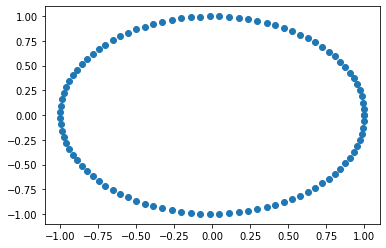

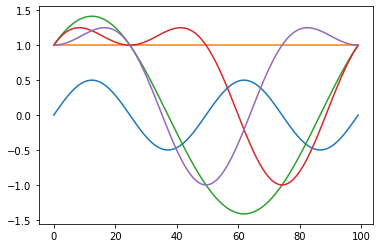

In [160]:
N = 100
D = 5

# 真の潜在変数を生成
t = np.linspace( 0, 2*np.pi, N )
z_true = np.zeros( (N, 2)  )

z_true[:,0] = np.cos(t)
z_true[:,1] = np.sin(t)

plt.plot( z_true[:,0], z_true[:,1], "o" )

# 潜在変数を適当に高次限化
x = np.zeros( (N, D) )
x[:,0] = [ z1*z2 for (z1,z2) in z_true ] 
x[:,1] = [ z1*z1+z2*z2 for (z1,z2) in z_true ] 
x[:,2] = [ z1 + z2 for (z1,z2) in z_true ] 
x[:,3] = [ z1*z1+z2 for (z1,z2) in z_true ] 
x[:,4] = [ z2*z2+z1 for (z1,z2) in z_true ] 

plt.figure()
for i in range(D):
  plt.plot( range(N), x[:,i])

PCA Loss: tensor(0.0248, dtype=torch.float64)
tensor(0.0467, dtype=torch.float64, grad_fn=<MeanBackward0>)


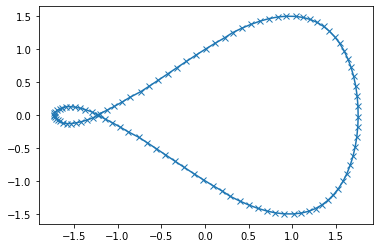

tensor(0.0014, dtype=torch.float64, grad_fn=<MeanBackward0>)


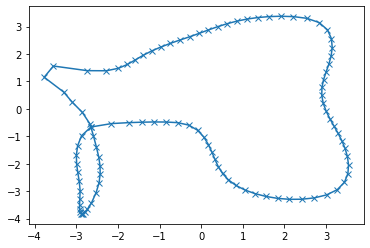

tensor(0.0006, dtype=torch.float64, grad_fn=<MeanBackward0>)


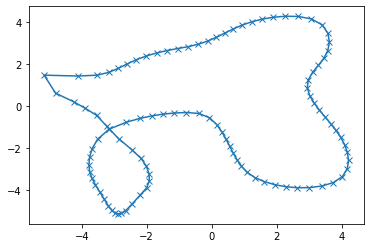

tensor(0.0003, dtype=torch.float64, grad_fn=<MeanBackward0>)


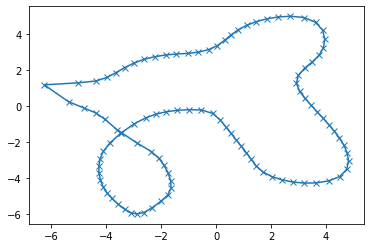

tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)


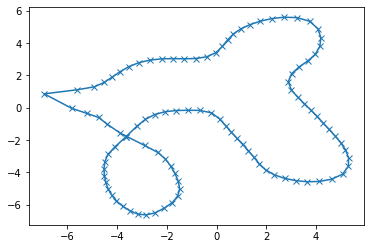

In [165]:
ukr = UKR(2)
ukr.learn( x )